In [1]:
# Import and install requierd package
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import datasets, layers, models, losses
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [2]:
# Utility Functions
def average(input_data):
    return sum(input_data)/len(input_data)

def train_result(history, module_type='Train'):
  results = {
      'Loss' : history.history['loss'][-1] ,
      'Accuracy' : history.history['accuracy'][-1],
      'Precision' : history.history['precision'][-1],
      'Recall' : history.history['recall'][-1],
      'F1 Score' : history.history['f1_score'][-1],
      'Specificity': history.history['specificity_at_sensitivity'][-1],
      'Mean Absolute Error':history.history['mean_absolute_error'][-1],
      'R2 Score' : history.history['r_square'][-1],
      }
  return pd.DataFrame.from_dict(results, orient="index", columns=[module_type])
def test_result(history, module_type='Test'):
  results = {
      'Loss' : history[0] ,
      'Accuracy' : history[1],
      'Precision' : history[2],
      'Recall' :history[3],
      'F1 Score' : history[4],
      'Specificity': history[5],
      'Mean Absolute Error': history[6],
      'R2 Score' : history[7],
      }
  return pd.DataFrame.from_dict(results, orient="index", columns=[module_type])

In [3]:
# Load Mnist Dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2, 2], [2, 2]]) / 255
x_test = tf.pad(x_test, [[0, 0], [2, 2], [2, 2]]) / 255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
# x_val = x_train[-2000:, :, :, :]
# y_val = y_train[-2000:]
# x_train = x_train[:-2000, :, :, :]
# y_train = y_train[:-2000]
x_val = x_test
y_val =y_test

num_classes=10

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# AlexNet structure based on its article
model = models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Resizing(224, 224, input_shape=x_train.shape[1:])) # Resize Data
model.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))
model.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides=2))
model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                        

In [5]:
# Model Setting
learning_rate = 0.5
weight_decay = 5e-4
batch_size = 256
epochs = 30
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tfa.metrics.F1Score(num_classes,average='macro'),
                      tf.keras.metrics.SpecificityAtSensitivity(0.5),
                      tf.keras.metrics.MeanAbsoluteError(),
                      tfa.metrics.RSquare()]


In [6]:
# Compile model 
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# Train Model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Model Evaluation
evaluate_result = model.evaluate(x_test, y_test, batch_size=batch_size)
print(evaluate_result)

Epoch 1/30
235/235 [==============================] - 125s 480ms/step - loss: 2.1410 - accuracy: 0.1940 - precision: 0.8644 - recall: 0.0548 - f1_score: 0.1309 - specificity_at_sensitivity: 0.4938 - mean_absolute_error: 0.1691 - r_square: 0.0539 - val_loss: 2.2352 - val_accuracy: 0.1441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0785 - val_specificity_at_sensitivity: 0.5500 - val_mean_absolute_error: 0.1779 - val_r_square: 0.0137
Epoch 2/30
235/235 [==============================] - 110s 469ms/step - loss: 1.6077 - accuracy: 0.3479 - precision: 0.7729 - recall: 0.1433 - f1_score: 0.3242 - specificity_at_sensitivity: 0.8841 - mean_absolute_error: 0.1425 - r_square: 0.1950 - val_loss: 1.3961 - val_accuracy: 0.4239 - val_precision: 0.9563 - val_recall: 0.1183 - val_f1_score: 0.3108 - val_specificity_at_sensitivity: 0.9183 - val_mean_absolute_error: 0.1361 - val_r_square: 0.2559
Epoch 3/30
235/235 [==============================] - 110s 469ms/step - loss: 1.2756

In [7]:
# Results
train_results = train_result(history, module_type='Train')
test_results = test_result(evaluate_result, module_type='Test')
final_result = pd.concat([train_results, test_results], axis=1)
print(final_result)


                        Train      Test
Loss                 0.000738  0.055895
Accuracy             0.999950  0.989200
Precision            0.999950  0.989692
Recall               0.999950  0.988900
F1 Score             0.999950  0.989113
Specificity          0.999996  0.999656
Mean Absolute Error  0.000083  0.002287
R2 Score             0.999848  0.979181


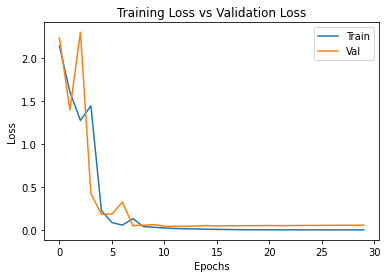

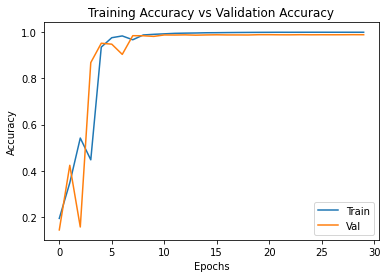

In [8]:
#Plot Results
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()
